In [1]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from ipynb.fs.full.plotter_class import Plotter
from ipynb.fs.full.time_series_data import TimeSeriesData
from ipynb.fs.full.dataset_creator import SupervisedDatasetCreator
from ipynb.fs.full.dataset_scaler_manager import DataScalerManager
from ipynb.fs.full.lstm import LSTMModel

class MiltivariadoPipeline:
    def __init__(self, config):
        self.config = config
        self.data_scaler_manager = DataScalerManager()
        self.ts_data = TimeSeriesData(self.config['data_path'], self.config['file_name'])
        self.column_target = self.config['column_target']
        self.lstm_model = None
        self.scaler = None
        self.data = None
        self.dataset = None
        self.y_test_pred = None
                       
    def create_supervised_data(self):            
        target_column_name = self.config['column_target']
        target_column_index = self.data['test'].columns.get_loc(self.config['column_target'])
        
        preprocessor = SupervisedDatasetCreator(self.config['input_length'], self.config['output_length'], target_column_index)
        x_train, y_train = preprocessor.create_supervised_dataset(self.data['train'].values)
        x_val, y_val = preprocessor.create_supervised_dataset(self.data['val'].values)
        x_test, y_test = preprocessor.create_supervised_dataset(self.data['test'].values)

        self.data.update({
            'x_train': x_train, 'y_train': y_train,
            'x_val': x_val, 'y_val': y_val,
            'x_test': x_test, 'y_test': y_test
        })
                                
    def build_model(self):
        input_shape = (self.data['x_train'].shape[1], self.data['x_train'].shape[2])
        lstm_model = LSTMModel(n_units=self.config['n_units'], input_shape=input_shape, output_shape=self.config['output_length'], learning_rate=self.config['learning_rate'])
        self.lstm_model = lstm_model.model   
        
    def drop_column(self, column):
        return self.dataset.drop(column, axis=1)
    
    def drop_columns(self, columns):
        for column in columns:
            self.dataset = self.drop_column(column)
        
    def evaluate_model(self):
        rmse_train = self.lstm_model.evaluate(self.data['x_train'], self.data['y_train'], verbose=0)
        rmse_val = self.lstm_model.evaluate(self.data['x_val'], self.data['y_val'], verbose=0)
        rmse_test = self.lstm_model.evaluate(self.data['x_test'], self.data['y_test'], verbose=0)

        print('RMSE Comparison:')
        print(f'  RMSE Train: {rmse_train:.3f}')
        print(f'  RMSE Val: {rmse_val:.3f}')
        print(f'  RMSE Test: {rmse_test:.3f}')
    
    def feature_engineering(self):
        w_dir = self.dataset['wd (deg)'] * np.pi / 180    
        Wx = self.dataset['wv (m/s)'] * np.cos(w_dir)
        Wy = self.dataset['wv (m/s)'] * np.sin(w_dir)
        
        self.dataset = self.dataset.drop(columns=['wd (deg)', 'wv (m/s)', 'max. wv (m/s)'])    
        self.dataset['Wx'] = Wx
        self.dataset['Wy'] = Wy
        
    def plot_datasets(self):
        """
        Plots subplots for each variable in the dataset with corresponding legends and titles.
        """
        fig, ax = plt.subplots(figsize = (16,5))
        ax.plot(self.data['train'][self.config['column_target']], label='Train')
        ax.plot(self.data['val'][self.config['column_target']], label='Val')
        ax.plot(self.data['test'][self.config['column_target']], label='Test')
        ax.set_title(f'{self.config["column_target"]} over Time')
        plt.legend()
                
        
        
        # num_variables = len(self.data['train'].columns)
        # variables = self.data['train'].columns
        
        # fig, axes = plt.subplots(num_variables, 1, figsize=(12, 4 * num_variables), sharex=True)
        
        # if num_variables == 1:
        #     axes = [axes]  
        
        # for i, var in enumerate(variables):
        #     ax = axes[i]
        #     ax.plot(self.data['train'][var], label='Train')
        #     ax.plot(self.data['val'][var], label='Val')
        #     ax.plot(self.data['test'][var], label='Test')
            
        #     ax.set_title(f'{var} over Time')
        #     ax.set_ylabel(var)
        #     ax.legend()
        
        # axes[-1].set_xlabel('Time')
        # plt.tight_layout()
        # plt.show()
        
    def plot_predictions(self):
        column_target = self.config['column_target']      
        plotter = Plotter()
        plotter.plot(self.data['test'][column_target].values, label='True')
        plotter.plot(self.y_test_pred, label='Predicted')
        plotter.configure(title=f'True vs Predicted for {column_target}', xlabel='Time Steps', ylabel=column_target)
        plotter.show()
        
    def plot_prediction_errors(self):
        N = len(self.y_test_pred)  
        ndato = np.linspace(1, N, N)

        errores = self.data['y_test'].flatten() - self.y_test_pred
        plt.plot(ndato, errores)
        plt.xlabel('Prediction index')
        plt.ylabel('Prediction error')
        plt.title('Prediction errors')
        plt.show()
        
    def plot_rmse_over_timesteps(self):
        y_test_pred_scaled = self.lstm_model.predict(self.data['x_test'], verbose=0)
        y_test_pred = self.scaler.inverse_transform(y_test_pred_scaled)

        diff_cuad = np.square(self.data['y_test'].squeeze() - y_test_pred)
        proms = np.mean(diff_cuad, axis=0)
        rmse = np.sqrt(proms)

        t = np.linspace(1, self.config['output_length'], self.config['output_length'])
        fig, ax = plt.subplots()
        ax.scatter(t, rmse)
        ax.set_xlabel('Predicted Timestep')
        ax.set_ylabel('RMSE Error (°C)')
        plt.xticks(ticks=t, labels=t)
        plt.grid()
        plt.show()    
        
    def plot_training_history(self, history):
        plotter = Plotter()
        
        plotter.plot(history.history['loss'], label='RMSE Train')
        plotter.plot(history.history['val_loss'], label='RMSE Val')
        plotter.configure(title='Epochs vs RMSE', xlabel='Epochs', ylabel='RMSE')
        plotter.show()  
        
    def predict(self, x):
        y_pred_scaled = self.lstm_model.predict(x, verbose=0)
        y_pred = self.scaler.inverse_transform(y_pred_scaled)
        self.y_test_pred = y_pred.flatten()
        
    def read_file(self):
        ts_data = TimeSeriesData(self.config['data_path'], self.config['file_name'])
        
        if 'columns_dataset' in self.config and self.config['columns_dataset']:
            series = ts_data.df[self.config['columns_dataset']]
        else:
            series = ts_data.df  
        
        self.dataset = series
    
    def split_data(self):
        train, val, test = self.ts_data.train_val_test_split(self.dataset)
        self.data = {'train': train, 'val': val, 'test': test}
        
    def scale_data(self):        
        col_ref = self.dataset.columns.get_loc(self.column_target)  
        scaled_data, self.scaler = self.data_scaler_manager.scale_data(self.data, col_ref)
        self.data.update(scaled_data)
        
    def train_model(self):
        early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-7)

        history = self.lstm_model.fit(
            self.data['x_train'], self.data['y_train'],
            epochs=self.config['epochs'],
            batch_size=self.config['batch_size'],
            validation_data=(self.data['x_val'], self.data['y_val']),
            callbacks=[early_stopping, reduce_lr],
            verbose=2
        )

        self.plot_training_history(history)
                
    def plot_violin_plots(self, x_train=None, x_val=None, x_test=None, y_train=None, y_val=None, y_test=None, feature_names=None, figsize=(12, 4)):
        fig, ax = plt.subplots(figsize=figsize)
        
        if x_train is not None and x_val is not None and x_test is not None and feature_names is not None:
            num_features = x_train.shape[2]
            
            for i in range(num_features):
                train_data = x_train[:, :, i].flatten()
                val_data = x_val[:, :, i].flatten()
                test_data = x_test[:, :, i].flatten()
                
                ax.violinplot(dataset=train_data, positions=[i], showmeans=True, showmedians=True)
                ax.violinplot(dataset=val_data, positions=[i], showmeans=True, showmedians=True)
                ax.violinplot(dataset=test_data, positions=[i], showmeans=True, showmedians=True)
            
            ax.set_xticks(list(range(num_features)))
            ax.set_xticklabels(feature_names, rotation=90)
        
        elif y_train is not None and y_val is not None and y_test is not None:
            ax.violinplot(dataset=y_train.flatten(), positions=[0], showmeans=True, showmedians=True)
            ax.violinplot(dataset=y_val.flatten(), positions=[1], showmeans=True, showmedians=True)
            ax.violinplot(dataset=y_test.flatten(), positions=[2], showmeans=True, showmedians=True)
            
            ax.set_xticks([0, 1, 2])
            ax.set_xticklabels(['Train', 'Val', 'Test'])
        
        else:
            raise ValueError("Invalid input: Provide either x_train, x_val, x_test, and feature_names or y_train, y_val, and y_test.")
        
        ax.autoscale()        
        plt.show()
                    
    def run(self):
        self.read_file()
        self.drop_columns(['datetime'])
        if self.config['feature_engineering']:
            self.feature_engineering
        self.split_data()
        if self.config['plot']:
            self.plot_datasets()        
        self.create_supervised_data()
        self.scale_data()
        if self.config['plot']:
            self.plot_violin_plots(x_train=self.data['x_train'], x_val=self.data['x_val'], x_test=self.data['x_test'], feature_names=self.dataset.keys())
            self.plot_violin_plots(y_train=self.data['y_train'], y_val=self.data['y_val'], y_test=self.data['y_test'])
        self.build_model()
        self.train_model()
        self.evaluate_model()
        self.predict(self.data['x_test'])
        if self.config['plot']:
            self.plot_predictions()
            if self.config['output_length'] > 1:
                self.plot_rmse_over_timesteps()

In [2]:
# Configuration dictionary
config = {
    'data_path': './../data/',
    'file_name': 'weather_dataset_preprocesado.csv',
    #'columns_dataset': ['datetime', 'p (mbar)', 'T (degC)', 'Tpot (K)'], 
    'column_target': 'T (degC)',   
    'input_length': 24,
    'output_length': 1,
    'epochs': 20,
    'batch_size': 256,
    'learning_rate': 5e-4, #2.8e-4,
    'n_units': 256,
    'plot': True,
    'feature_engineering': True
}

pipeline = MiltivariadoPipeline(config)

In [3]:
pipeline.read_file()
pipeline.dataset = pipeline.dataset.reset_index()
pipeline.drop_columns(['datetime'])
# pipeline.feature_engineering()
# pipeline.split_data()
# pipeline.plot_datasets()


In [4]:
pipeline.dataset

,index,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
50220,50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
50221,50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5
50222,50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,2.86,4.32,172.0


In [5]:
pipeline.feature_engineering()

In [6]:
pipeline.split_data()

In [7]:
pipeline.data['test']

,index,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy
45201,45201,991.70,6.70,280.53,4.40,85.20,9.82,8.37,1.45,5.27,8.44,1230.49,-0.768286,0.624369
45202,45202,990.98,8.20,282.09,4.77,78.90,10.89,8.59,2.30,5.41,8.67,1222.94,-0.318947,-0.830887
45203,45203,990.17,8.74,282.70,4.20,73.10,11.29,8.25,3.04,5.20,8.34,1219.76,-2.109770,-0.722336
45204,45204,989.22,9.01,283.05,3.68,69.18,11.50,7.96,3.54,5.02,8.04,1217.56,-3.458855,-1.313896
45205,45205,988.42,9.28,283.38,2.50,62.46,11.71,7.32,4.40,4.62,7.40,1215.70,-3.786828,-2.412475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,-2.904532,0.300154
50220,50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,-1.558297,0.191335
50221,50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,-2.577624,-1.067687
50222,50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,-2.832167,0.398035


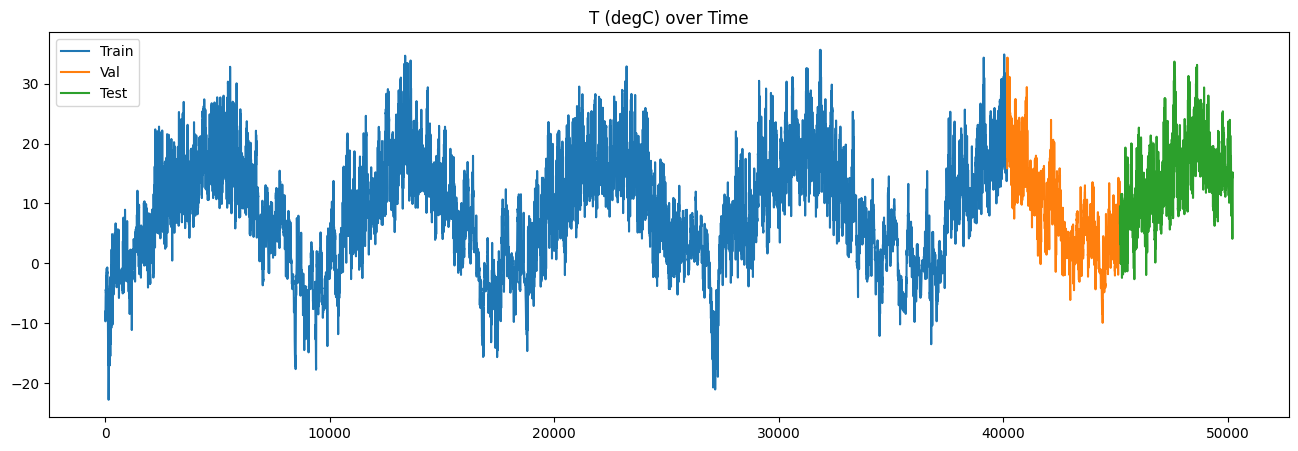

In [8]:
pipeline.plot_datasets()

In [9]:
pipeline.data['test']

,index,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy
45201,45201,991.70,6.70,280.53,4.40,85.20,9.82,8.37,1.45,5.27,8.44,1230.49,-0.768286,0.624369
45202,45202,990.98,8.20,282.09,4.77,78.90,10.89,8.59,2.30,5.41,8.67,1222.94,-0.318947,-0.830887
45203,45203,990.17,8.74,282.70,4.20,73.10,11.29,8.25,3.04,5.20,8.34,1219.76,-2.109770,-0.722336
45204,45204,989.22,9.01,283.05,3.68,69.18,11.50,7.96,3.54,5.02,8.04,1217.56,-3.458855,-1.313896
45205,45205,988.42,9.28,283.38,2.50,62.46,11.71,7.32,4.40,4.62,7.40,1215.70,-3.786828,-2.412475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,-2.904532,0.300154
50220,50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,-1.558297,0.191335
50221,50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,-2.577624,-1.067687
50222,50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,-2.832167,0.398035


In [10]:
pipeline.create_supervised_data()

column_index: 2
column_index: 2
column_index: 2


In [13]:
pipeline.data['y_train'].shape

(40154, 1, 1)

In [14]:
pipeline.data['y_test']

array([[[ 4.92]],

       [[ 5.37]],

       [[ 6.4 ]],

       ...,

       [[14.19]],

       [[14.99]],

       [[15.2 ]]])

In [15]:
pipeline.scale_data()

In [16]:
pipeline.data['x_train']

array([[[-1.        ,  0.67086567, -0.49631912, ...,  0.48708432,
          0.13560416,  0.02799929],
        [-1.        ,  0.67328429, -0.52473891, ...,  0.51336466,
          0.13139868,  0.02818259],
        [-1.        ,  0.67771843, -0.52234206, ...,  0.51294561,
          0.13860518,  0.03874957],
        ...,
        [-1.        ,  0.74140885, -0.3747646 , ...,  0.40842288,
          0.12289751,  0.03685858],
        [-1.        ,  0.73677315, -0.37373737, ...,  0.40584872,
          0.10510486, -0.01766849],
        [-1.        ,  0.73314522, -0.37613422, ...,  0.40608818,
          0.11854819,  0.05541536]],

       [[-0.99995019,  0.67328429, -0.52473891, ...,  0.51336466,
          0.13139868,  0.02818259],
        [-0.99995019,  0.67771843, -0.52234206, ...,  0.51294561,
          0.13860518,  0.03874957],
        [-0.99995019,  0.68074171, -0.53055984, ...,  0.52150618,
          0.15144667,  0.02294753],
        ...,
        [-0.99995019,  0.73677315, -0.37373737, ...,  

In [ ]:
pipeline.plot_violin_plots(x_train=pipeline.data['x_train'], x_val=pipeline.data['x_val'], x_test=pipeline.data['x_test'], feature_names=pipeline.dataset.keys())

In [ ]:
pipeline.plot_violin_plots(y_train=pipeline.data['y_train'], y_val=pipeline.data['y_val'], y_test=pipeline.data['y_test'])

In [17]:
pipeline.build_model()

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
157/157 - 48s - 305ms/step - loss: 0.0673 - val_loss: 0.0381 - learning_rate: 5.0000e-04
Epoch 2/20
157/157 - 42s - 268ms/step - loss: 0.0416 - val_loss: 0.0291 - learning_rate: 5.0000e-04
Epoch 3/20
157/157 - 56s - 354ms/step - loss: 0.0352 - val_loss: 0.0248 - learning_rate: 5.0000e-04
Epoch 4/20
157/157 - 57s - 364ms/step - loss: 0.0328 - val_loss: 0.0268 - learning_rate: 5.0000e-04
Epoch 5/20
157/157 - 62s - 393ms/step - loss: 0.0313 - val_loss: 0.0238 - learning_rate: 5.0000e-04
Epoch 6/20
157/157 - 50s - 320ms/step - loss: 0.0307 - val_loss: 0.0246 - learning_rate: 5.0000e-04
Epoch 7/20
157/157 - 48s - 307ms/step - loss: 0.0301 - val_loss: 0.0236 - learning_rate: 5.0000e-04
Epoch 8/20
157/157 - 50s - 316ms/step - loss: 0.0299 - val_loss: 0.0249 - learning_rate: 5.0000e-04
Epoch 9/20
157/157 - 55s - 351ms/step - loss: 0.0297 - val_loss: 0.0232 - learning_rate: 5.0000e-04
Epoch 10/20
157/157 - 50s - 320ms/step - loss: 0.0294 - val_loss: 0.0230 - learning_rate: 5.0000e-04

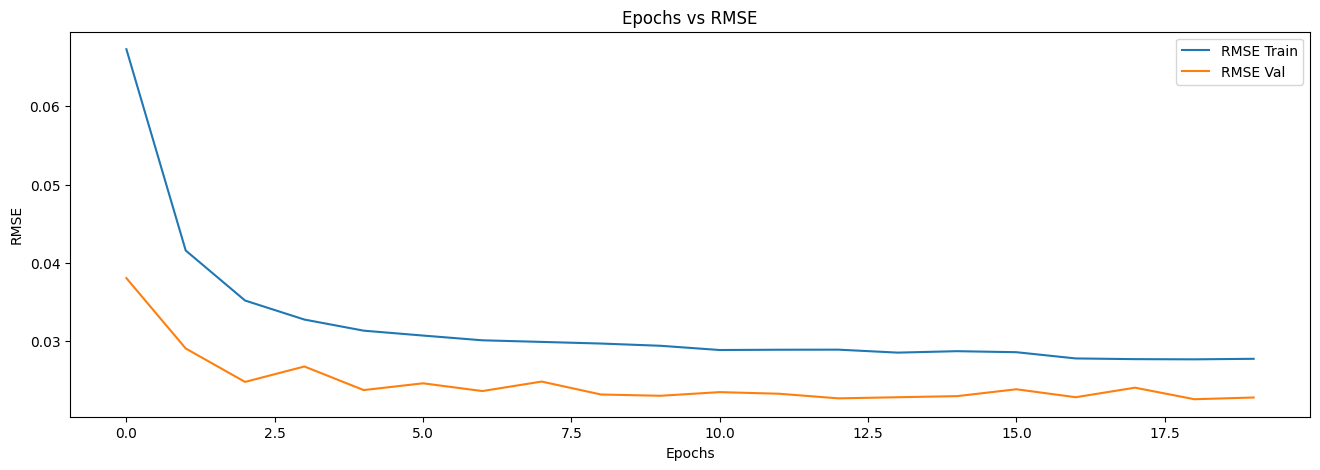

In [19]:
pipeline.train_model()

In [20]:
pipeline.evaluate_model()

RMSE Comparison:
  RMSE Train: 0.023
  RMSE Val: 0.022
  RMSE Test: 0.026


In [22]:
pipeline.predict(pipeline.data['x_test'])

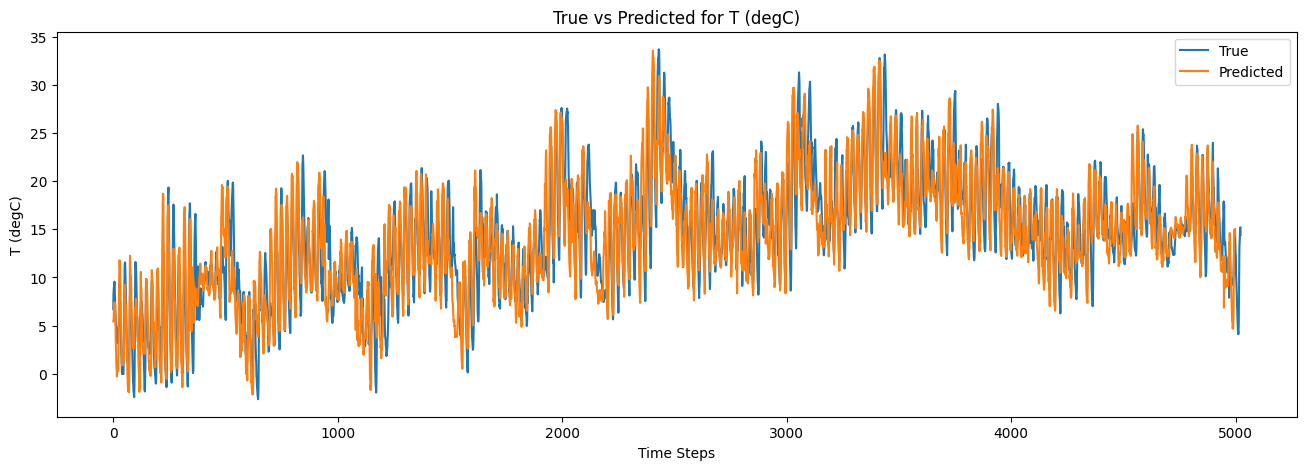

In [23]:
pipeline.plot_predictions()